In [212]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

# OBTENDO DADOS

In [213]:
df = pd.read_csv('DataBase.csv')
print('size:', len(df))
df.head()

size: 2304


,input,output,time
0,255,1008,2.160
1,255,821,2.175
2,255,699,2.190
3,255,495,2.250
4,255,472,2.265


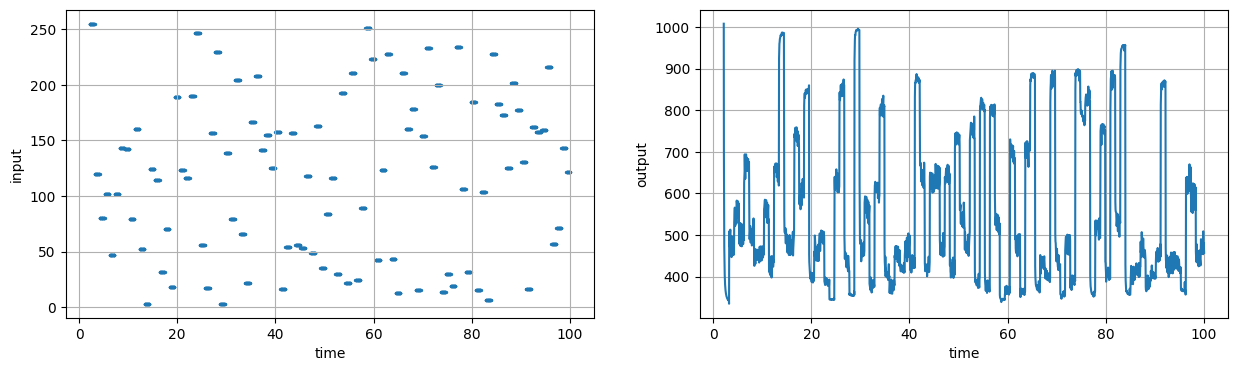

In [214]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.scatter(df.time, df.input, s=2)
plt.xlabel('time'), plt.ylabel('input')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df.time, df.output)
plt.xlabel('time'), plt.ylabel('output')
plt.grid()

# PADRONIZANDO OS DADOS

In [215]:
def normalizeData(df, timeKey, responseKey, T=0.15):
    initTime  = df[timeKey].iloc[0]
    finalTime = df[timeKey].iloc[-1] + T
    timeData = np.arange(initTime, finalTime, T)
    
    lastValue  = df[responseKey].iloc[0]
    desired = []

    for t in timeData:
        filtered = df.loc[df[timeKey] <= t][responseKey]
        
        if not filtered.empty:
            lastValue = filtered.iloc[-1]
        
        desired.append(lastValue)
    
    return timeData, desired


def normalizeTable(df, key, T=0.15):
    table = {key: []}

    for column in df.columns:
        if column == key:
            continue

        xData, yData = normalizeData(df, key, column, T)
        table[column] = yData

    table[key] = xData
    return pd.DataFrame(table) 


T = 0.01
df = normalizeTable(df, 'time', T)
print('size:', len(df))
df.head()

size: 9789


,time,input,output
0,2.16,255,1008
1,2.17,255,1008
2,2.18,255,821
3,2.19,255,821
4,2.20,255,699


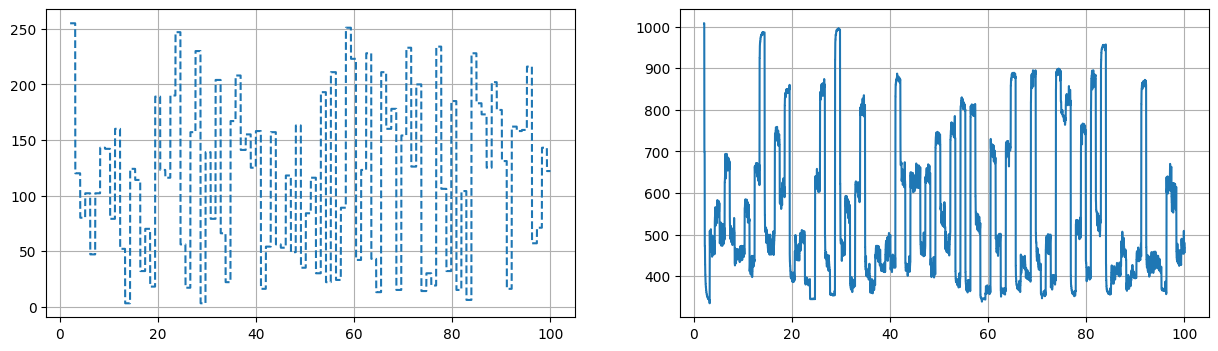

In [216]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(df.time, df.input, '--')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df.time, df.output)
plt.grid()

# MODELO DE MACHINE LEARNING

In [217]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [218]:
tData, uData, yData = df.time.values, df.input.values, df.output.values
N = len(df)
N

9789

In [219]:
def getStates(df, key, var='y', n=10):
    table = df.copy() 
    table[f'{var}n'] = table[key]

    for i in range(1, n):
        table[f'{var}n{i}'] = table[key].shift(i)

    table.fillna(0, inplace=True)
    columns = [f'{var}n'] + [f'{var}n{i}' for i in range(1, n)]
    return table[columns]


n = 15
yData = df.output.values
xData = getStates(df, 'input', 'X', n)
xData

,Xn,Xn1,Xn2,Xn3,Xn4,Xn5,Xn6,Xn7,Xn8,Xn9,Xn10,Xn11,Xn12,Xn13,Xn14
0,255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,255,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,255,255.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,255,255.0,255.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,255,255.0,255.0,255.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9784,122,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0
9785,122,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0
9786,122,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0
9787,122,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0,122.0


In [220]:
def getTrainArrays(xData, yData):
    N = len(xData)
    
    if N % 2 != 0:
        N = N - 1
        xData = xData[:N]
        yData = yData[:N]
    
    N = N // 2
    xTrain, yTrain = xData[:N], yData[:N]
    xTest,  yTest  = xData[N:], yData[N:]
    return xTrain, xTest, yTrain, yTest


xTreino, xTeste, yTreino, yTeste = getTrainArrays(xData, yData)
xTreino

,Xn,Xn1,Xn2,Xn3,Xn4,Xn5,Xn6,Xn7,Xn8,Xn9,Xn10,Xn11,Xn12,Xn13,Xn14
0,255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,255,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,255,255.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,255,255.0,255.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,255,255.0,255.0,255.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4889,84,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0
4890,84,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0
4891,84,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0
4892,84,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0


In [221]:
def plotModel(yTeste, yModel, score=None, tData=None):
    plt.figure(figsize=(10, 5))
    
    if tData is None:
        tData = range(yTeste.shape[0])
    
    if score is not None:
        plt.title(f'Precisão do Modelo: {score*100:.2f}%')

    plt.plot(tData, yTeste, label='test')
    plt.plot(tData, yModel, color='orange', label='predicted')
    plt.xlabel('Referência'), plt.ylabel('Valores')
    plt.legend(), plt.grid()
    plt.show()

### REGRESSÃO LINEAR

In [222]:
from sklearn.linear_model import LinearRegression

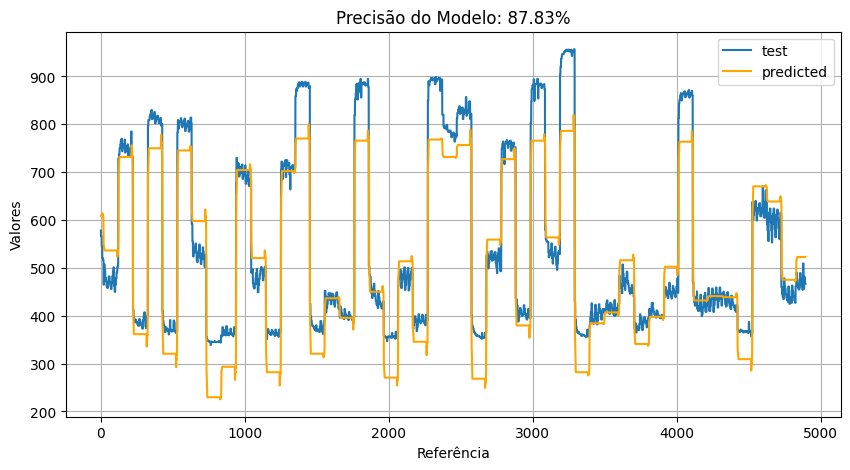

In [223]:
def linearRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = getTrainArrays(xData, yData)
    model = LinearRegression()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score)
    return model


linearModel = linearRegression(xData, yData)

### REGRESSÃO POLINOMIAL

In [224]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

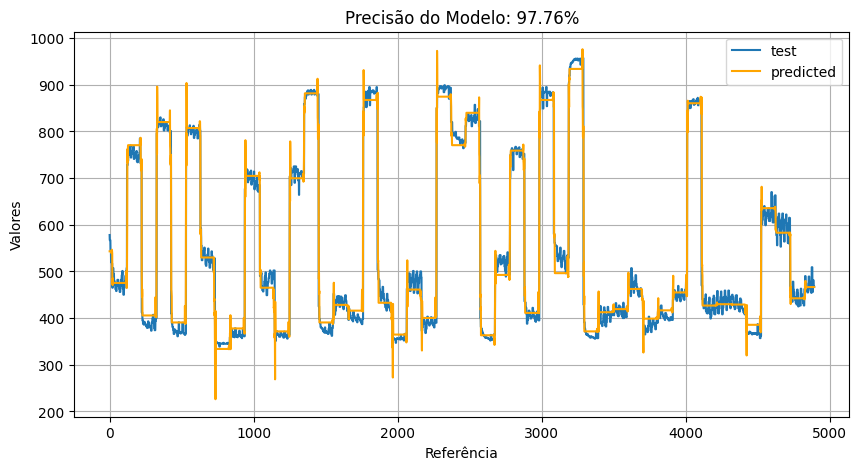

In [225]:
def polinomialRegression(xData, yData, degree=2):
    xTreino, xTeste, yTreino, yTeste = getTrainArrays(xData, yData)
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score)
    return model


polinomialModel = polinomialRegression(xData, yData, degree=3)

### ÁRVORE DE DECISÃO

In [226]:
from sklearn.tree import DecisionTreeRegressor

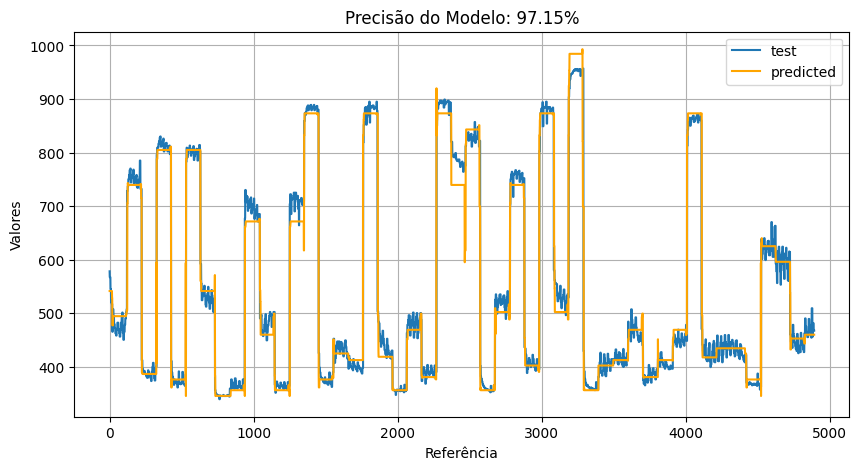

In [227]:
def decisionTreeRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = getTrainArrays(xData, yData)
    model = DecisionTreeRegressor()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score)
    return model


decisionModel = decisionTreeRegression(xData, yData)

### RANDOM FOREST

In [228]:
from sklearn.ensemble import RandomForestRegressor

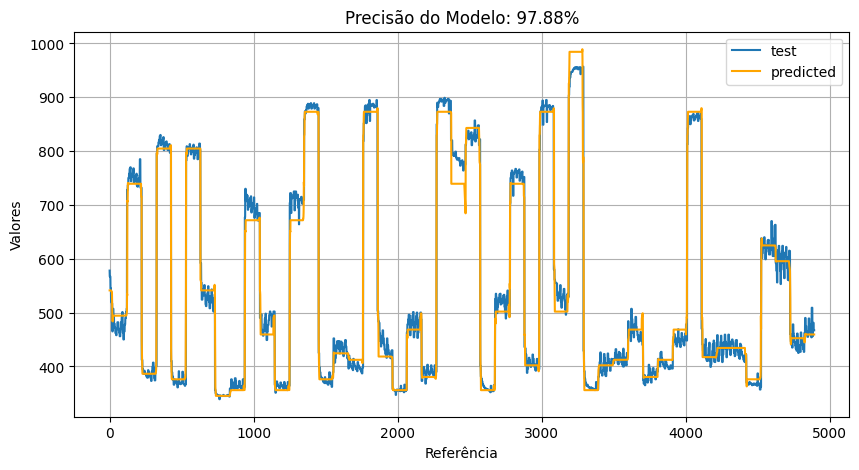

In [229]:
def randomForestRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = getTrainArrays(xData, yData)
    model = RandomForestRegressor()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score)
    return model


forestModel = randomForestRegression(xData, yData)

### SUPORTE VETORIAL PARA REGRESSÃO (SVR)

In [230]:
from sklearn.svm import SVR

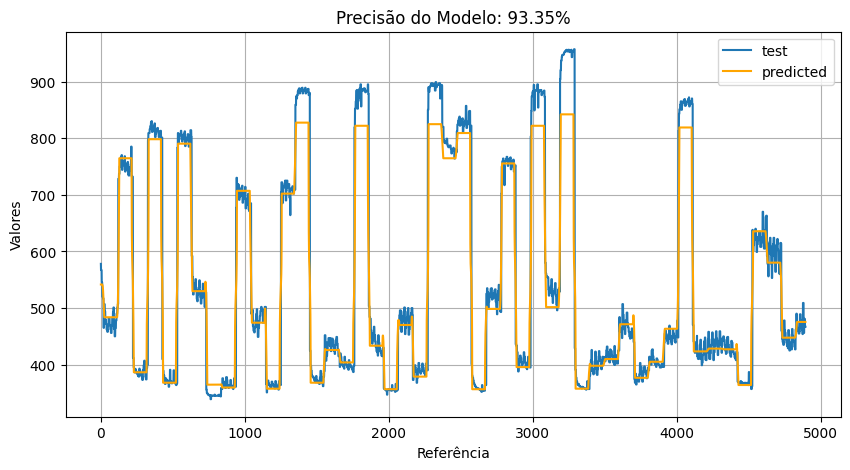

In [251]:
def supportVectorRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = getTrainArrays(xData, yData)
    model = SVR(kernel='rbf')  # kernel pode ser 'linear', 'poly', ou 'rbf'
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score)
    return model


vectorModel = supportVectorRegression(xData, yData)

### RIDGE REGRESSOR

In [232]:
from sklearn.linear_model import Ridge

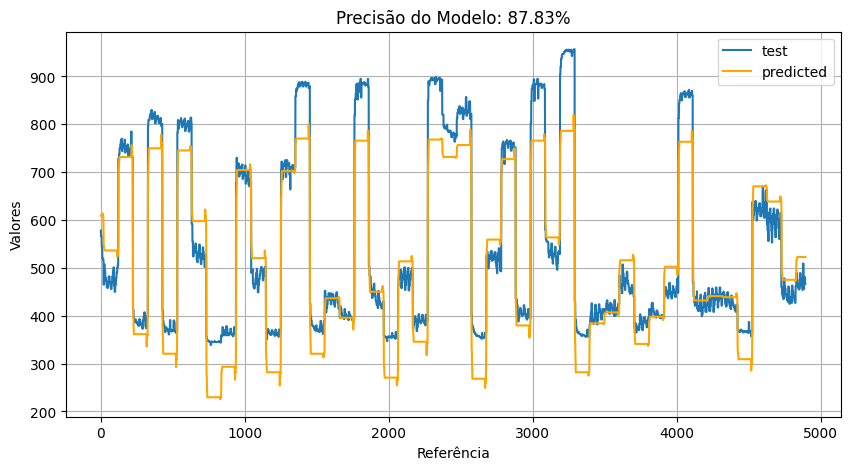

In [233]:
def ridgeRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = getTrainArrays(xData, yData)
    model = Ridge(alpha=1.0)  # Ajuste o parâmetro alpha para regularização
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score)
    return model


ridgeModel = ridgeRegression(xData, yData)

### GRADIENT BOOSTER

In [234]:
from sklearn.ensemble import GradientBoostingRegressor

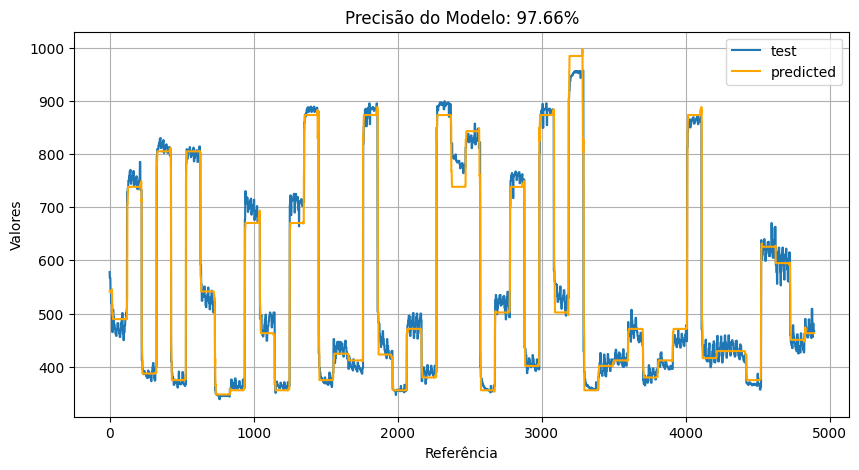

In [235]:
def gradientBoostingRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = getTrainArrays(xData, yData)
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score)
    return model


gradientModel = gradientBoostingRegression(xData, yData)

### K-NEAREST NEIGHBORS

In [236]:
from sklearn.neighbors import KNeighborsRegressor

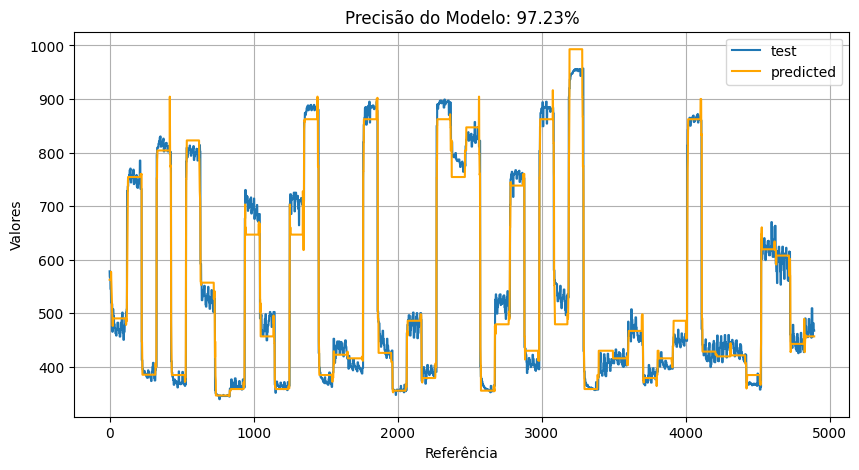

In [237]:
def knnRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = getTrainArrays(xData, yData)
    model = KNeighborsRegressor(n_neighbors=5)  # Ajuste n_neighbors conforme necessário
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score)
    return model


knnModel = knnRegression(xData, yData)

### ELASTIC NET

In [238]:
from sklearn.linear_model import ElasticNet

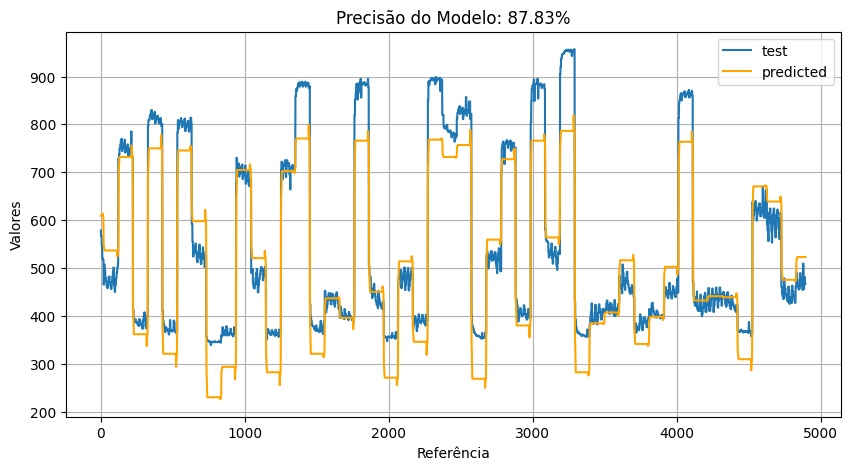

In [239]:
def elasticNetRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = getTrainArrays(xData, yData)
    model = ElasticNet(alpha=0.999, l1_ratio=0.5)  # Ajuste alpha e l1_ratio
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score)
    return model


elasticModel = elasticNetRegression(xData, yData)

### XGBOOST REGRESSOR

In [240]:
from xgboost import XGBRegressor

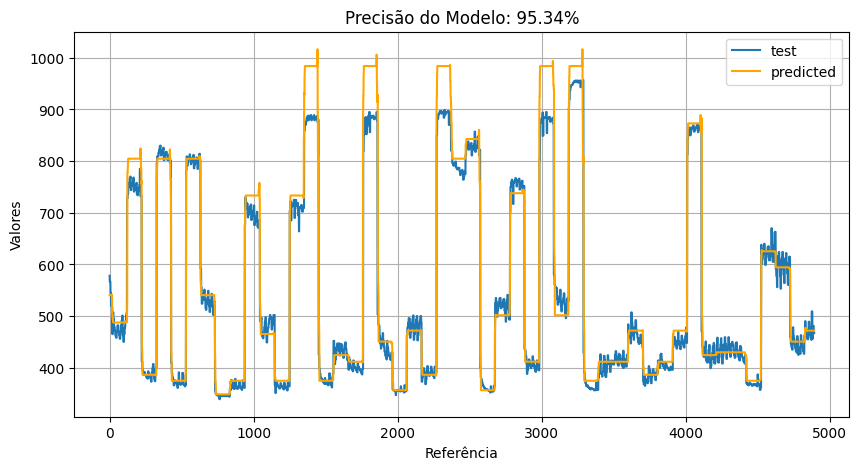

In [241]:
def xgboostRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = getTrainArrays(xData, yData)
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score)
    return model


xgboostModel = xgboostRegression(xData, yData)

### LASSO REGRESSION

In [242]:
from sklearn.linear_model import Lasso

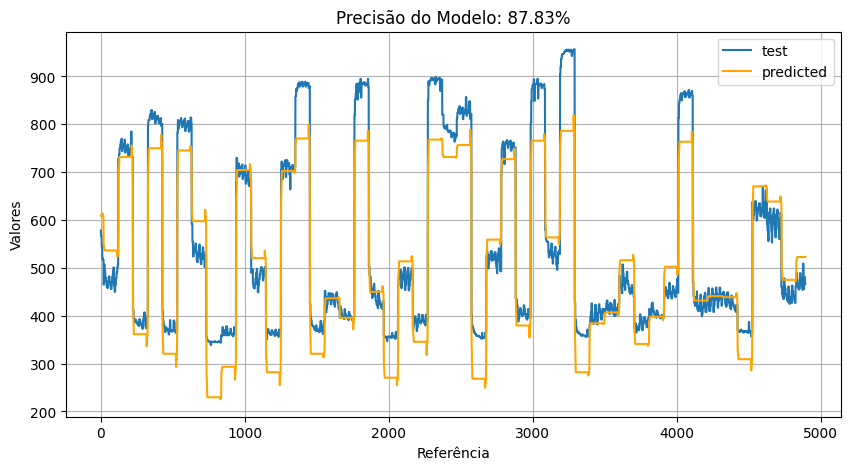

In [243]:
def lassoRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = getTrainArrays(xData, yData)
    model = Lasso(alpha=0.3)  # Ajuste alpha conforme necessário
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score)
    return model


lassoModel = lassoRegression(xData, yData)

### CATBOOST REGRESSION

In [244]:
from catboost import CatBoostRegressor

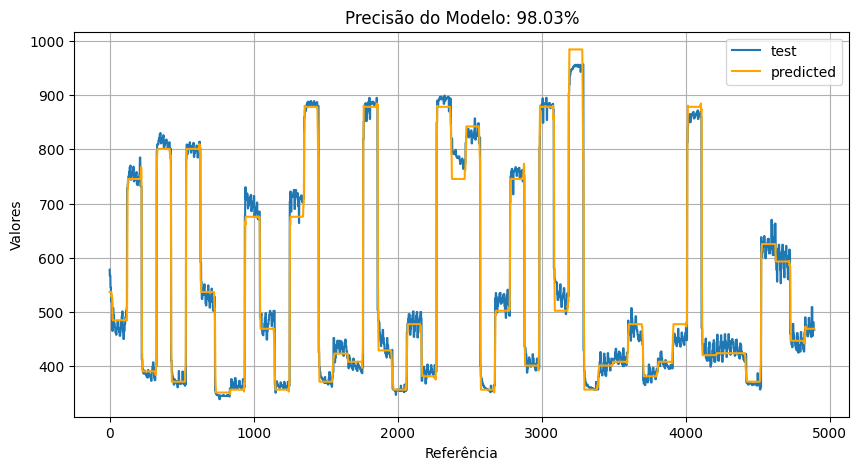

In [245]:
def catboostRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = getTrainArrays(xData, yData)
    model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=3, verbose=0)
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score)
    return model


catboostModel = catboostRegression(xData, yData)

### MULTI-LAYER PERCEPTRON (MLP)

In [246]:
from sklearn.neural_network import MLPRegressor

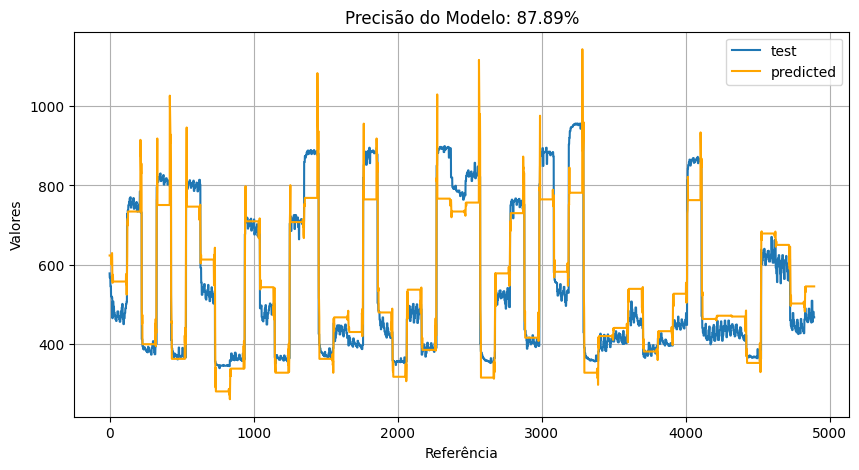

In [247]:
def mlpRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = getTrainArrays(xData, yData)
    model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    plotModel(yTeste, yModel, score)
    return model


mlpModel = mlpRegression(xData, yData)

# SIMULANDO A RESPOSTA

In [248]:
import joblib

joblib.dump(catboostModel, "model.pkl")
model = joblib.load("model.pkl")
model

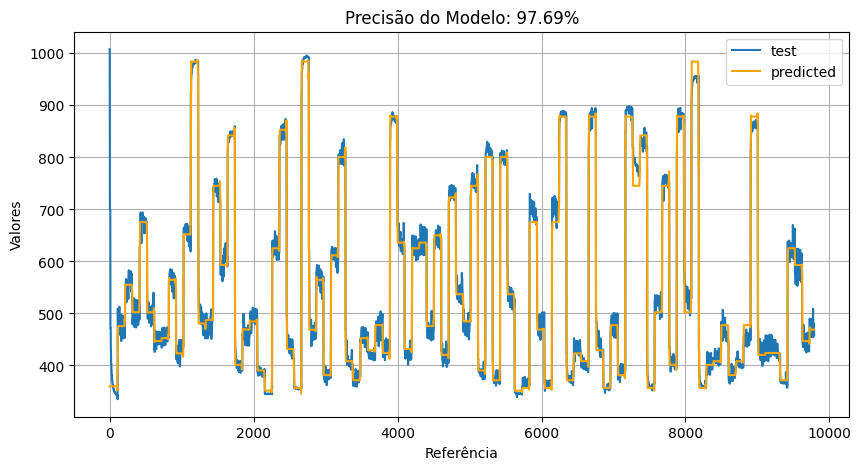

In [249]:
def simulateResponse(uData, Uo=0):
    states = Uo * np.ones(n)
    values = []

    for u in uData:
        for i in range(n-1, 0, -1):
            states[i] = states[i-1] # Xn3 = Xn2 ... Xn1 = Xn0

        states[0] = u # Xn
        yModel = model.predict([states])[0]
        values.append(yModel)

    return values


yModel = simulateResponse(df.input.values, Uo=0)
score  = metrics.r2_score(yData, yModel)
plotModel(yData, yModel, score)